From logistic regression to neural networks:

letting 
$$
a=x_1w_1+x_2w_2 \qquad p(y|x)=\frac{1}{1+e^{-a}}
$$
for the prediciton you can round to 1 or 0.

Various types of nonlinearities:

sigmoid(x): $$
s(x) = \frac{1}{1+e^{-x}}
$$
Tanh(x)
$$
t(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}
$$
relu(x)
$$
r(x)=\max(x,0)
$$


For data, suppose there are N samples, and D dimensions so that we have an $N \times D$ dimensional matrix X for the data, with $M$ nodes in the intermediate layer.  Then Z is an $N \times M$ matrix, and $p(Y|X)$ is an $N \times K$ vector for K classes.  The weights W must be 
$D \times M$ and b is $M \times 1$, and v is $M \times 1$ with a scalar c (or k dim vector is there are k classes).
$$
Z = s(XW+B), \qquad Y = s(Zv+C)
$$
where $B$ is $N$ stacked copies of $b^T$, since the bias must be added equally to each observation. (numpy does this automatically with x.dot(w)+b)  The same with C and the bias term c.
On an observation and node level, each $$
z_j=s \left(\sum_{i=1}^D w_{i,j}x_i +b_j \right), \qquad y_k=s \left(\sum_{j=1}^M v_{k,j}z_j+c_k \right)
$$

Softmax for k classes

$p(y=k|X)1= e^{a_k}/Z, \qquad Z = \sum_i e^{a_i}, $ with W a $D \times K$ matrix

$$
A_{N \times K}=X_{N \times D}W_{D \times K} \rightarrow Y_{N \times K} = \textrm{softmax} \left(A_{N \times K} \right)
$$

Softmax and sigmoid are equivalent is you divide the softmax term by $\exp(w_0^T x)$ and assigne new weights $w=w_1-w_0$

In [1]:
#Softmax in code
import numpy as np
np.random.seed(seed=3)
a = np.random.randn(5) #representing the activation at 5 different nodes at the output layer
#exponentiate everything
expa=np.exp(a)
denom=expa.sum()
answer = expa / denom
print(answer.sum())
#suppose instead of 5 elements we have many observations we want to classify
#thus we need to use a matrix
A=np.random.randn(100,5)
expA=np.exp(A) #all exponentiated element by element
#now we want every row to sum to 1, so we create a matrix where every row is the
# sum of a row of expA and divide by it (row by row)
divisor_matrix=expA.sum(axis=1,keepdims=True)
print(divisor_matrix[0])
print(expA[0])
ans=expA/divisor_matrix
print(ans[0])

1.0
[ 3.73375838]
[ 0.70134246  0.92058911  0.53419161  0.95712798  0.62050723]
[ 0.1878382   0.2465583   0.14307075  0.25634438  0.16618837]


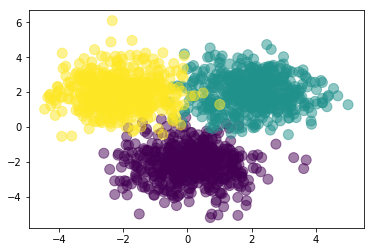

classification rate 0.3333333333333333


In [2]:
#building a feedforward neural net
# we will create several differnt gaussian classes here
import numpy as np
import matplotlib.pyplot as plt
nclass =500
x1=np.random.randn(nclass,2)+np.array([0,-2]) #changing mean vectors
x2=np.random.randn(nclass,2)+np.array([2,2])
x3=np.random.randn(nclass,2)+np.array([-2,2])
#labels
X=np.concatenate((x1,x2,x3),axis=0)
Y=np.array([0]*nclass+[1]*nclass+[2]*nclass)
plt.scatter(X[:,0],X[:,1],c=Y,s=100,alpha=0.5)
plt.show()
# the dimension D=2 and we want 3 hidden layers M=3
D,M,K=2,3,3
#now the weights
W1=np.random.randn(D,M)
b1=np.random.randn(M)
W2=np.random.randn(M,K)
b2=np.random.randn(K)
#now the forward (prediction) action of the network
def forward(x,w1,b1,w2,b2):
    Z=1/(1+np.exp(-x.dot(w1)-b1))#hidden layer
    A=Z.dot(w2)+b2 #pre-softmax
    expA=np.exp(A)
    Y=expA / expA.sum(axis=1,keepdims=True)#axis 0 coloumn 1 row
    return Y
def classification_rate(Y,P):
    correct=np.equal(Y,P)
    return float(correct.sum())/correct.size
# Y=np.array([1,2,3,1])
# P=np.array([1,2,1,1])
#classification_rate(Y,P)
P_y_given_x=forward(X,W1,b1,W2,b2)
Pred=np.argmax(P_y_given_x,axis=1)
assert(len(Pred)==len(Y))
print("classification rate "+str(classification_rate(Y,Pred)))

Now for training.  We create a cost function which we want to minimize, and then minimize it through gradient descent (backpropagation).  Backpropagation is recursive, moving from layer to layer.  

X is an N by D matrix of training inputs, and Y is a N by 1 matrix of training targets.  Our predictions P(Y|X) represent a probability distribusion over the values of Y given X, so is the same dimension as the one hot encoded Y, while P(Y=k|X) is a value, a single number typical of the entries in the matrix P(Y|X).

Other common notations include using X for inputs, T for targets, and Y for predictions (rather than P(Y|X)).  $W_i$ iw the weight input to the i th layer, and the same for $b_i$.

The learning rate is typically denoted by $\alpha$ or $\eta$ (e.g. $\theta \leftarrow \theta - \alpha \frac{\partial J}{\partial \theta}$)

The objective function, or cost function (error function) is typically represented by E or J.  Note that minimizing negative log-liklihood (gradient descent) is the same as maximizing log-liklihood (gradient ascent).  Typically L is for liklihood and l is for log-liklihood if both are presented together.

There are two basic ML functions:  train(X,Y) and predict(X).  

Letting $y_n, t_n$ represent the output of the model and the target value, we have cost in terms of cross entropy cost for two classes (binary) as   
$$
J= \sum_n t_n \log( y_n) + (1-t_n) \log(1-y_n)
$$
which is what we want to minimize.  However, for multi-class classification, with $y_{n,k},t_{n,k}$ representing the output of the model and target ($t_{n,K}=1$ if observation n is actually $k$ and $y_{n,k}$ the predicted probability of observation n being class k) and $y_k$ representing hte probability of output being $k$ and $t_k=1$ if class is $k$ and zero otherwise. 
Then liklihood is 
$$
\prod_{n=1}^N \prod_{k=1}^K y_{n,k}^{t_{n,k}}
$$
The values $t_{n,k}$ are entries in a one hot encoded matrix.  This leads to the cross entropy cost function for multi-class calssification.
$$
J= \sum_n \sum_k t_{n,k} \log y_{n,k}
$$

Training using backpropagation

Gradient ascent (maximizing log-liklihood)
$$
\omega \leftarrow \omega + \alpha \frac{\partial L}{\partial \omega }
$$
Recall the chain rule 
$$
\frac{\partial f}{\partial t }=\frac{\partial f}{\partial x }\frac{\partial x}{\partial t }+\frac{\partial f}{\partial y }\frac{\partial y}{\partial t }
$$
or, more generally, if $f$ depends on $x_1 \dots x_k$
$$
\frac{\partial f}{\partial t } = \sum_{i=1}^k \frac{\partial f}{\partial x_k } \frac{\partial x_k}{\partial t }
$$

The objective function for neural netws with softmax (N obs, K class) is the joint distribution over all observations
$$
P_{W,B}( Y | X)  =  \prod_{n=1}^N \prod_{k=1}^K y_{k,n}^{t_{k,n}}
$$
where y is the probability (conditioned on W,B) of class k in for observation n after softmaxing.  Now we take the log liklihood which will also be our objective function:
$$
J:=L = \sum_n \sum_k t_{k,n} \log y_{k,n} 
$$
In backpropogation we find the partials with respect to the last layer of weights first (V) and then use this to find the partials for the earlier layers (W).  So choosing a particular weight $v_{m,j}$ which feeds into the terminal layer (y) of softmax probabilties from the second to last layer.  Taking derivatives with respect to the equation above, we obtain
$$
\frac{\partial J}{\partial v_{m,j} } = \sum_n \sum_{k}  t_{k,n} \frac{1}{y_{k,n}} \frac{\partial y_{n,k}}{\partial v_{m,j} }
$$
Recalling how we derived the softmax funtion
$$
y_k=\frac{e^{a_k}}{\sum_j e^{a_j}} , \qquad a_k =  \vec v_{k}^T \cdot \vec z_m = \sum_m v_{m,k} z_m 
$$
Using the quotient rule, we find that the derivative of $y_j$ with respect to $a_k$ is $y_j(1-y_k)$ if $k=j$ and $-y_j y_k$ is $k \neq j$.  The Kronecker delta $\delta_{i,j}$ is 1 for $i = j$ and 0 if $i \neq j$, so we can use it to simplify our notation for the derivative of $y_j$ with respect to $a_k$, making the result 
$$
\frac{\partial y_j}{\partial a_k} = y_j(\delta_{j,k} - y_k)
$$
Taking the derivative of $a_k$ with respect to $v_{m,k}$ we find that
$$
\frac{\partial a_k}{\partial v_{m,k}} =z_m
$$



$$
\frac{\partial J}{\partial v_{m,j} } = \sum_n \sum_{k}  t_{k,n} \frac{1}{y_{k,n}} \frac{\partial y_{n,k}}{\partial v_{m,j} }= \sum_n \sum_{k}  t_{k,n} \frac{1}{y_{k,n}} y_{k,n}(\delta_{j,k}-y_{j,n})z_{m,n}
$$



Since exactly one $t_{n,k}$ is one, we find that 
$$
\frac{\partial J}{\partial v_{m,j} } = \sum_n \sum_{k}  t_{k,n} (\delta_{j,k}-y_{j,n})z_{m,n}=\sum_n z_{m,n}(t_{j,n}-y_{j,n})
$$
The key point here is that the information required to change the V weights can be obtained by examining the output from the previous layer (Z) and the difference between desired and obtained results $t-y$.

Now consider the first layer.  Taking one $w_{d,m}$, which is a term in every $y_{n,k}$ through $z_m=\sigma(\vec w_m^T \vec x)$, we obtain, 
$$
\frac{\partial J}{\partial w_{m,j}} = \sum_n \sum_k t_{n,k}\frac{1}{y_{n,k}} \frac{\partial y_{n,k}}{\partial z_{m} } \frac{\partial z_m}{\partial w_{m,d} } =\sum_n (t_{n,k}-y_{n,k})v_{m,k}\frac{\partial z_m}{\partial w_{m,d} }
$$
and since
$$
\frac{\partial z_m}{\partial w_{m,d} } = z(1-z)x,
$$
$$
\frac{\partial J}{\partial w_{m,j}} =\sum_n (t_{n,k}-y_{n,k})v_{m,k}z_m(1-z_m)x_{n,d}
$$
Note that the indices on the left are not summed over on the right




Suppose we have several hidden layers, $Z_1,\dots Z_\nu$, and weights $W_0 \dots W_\nu$.  To simplify notation, suppose we do update after every sample, and omit the n.
$$
\frac{\partial J}{\partial w_{m,d}^\nu } = (t_k-y_k)z_{s}^\nu
$$
$$
\frac{\partial J}{\partial w_{m,d}^{\nu-1} } = \sum_k(t_k-y_k)w_{s,k}^\nu z_{s}^\nu(1-z_{s}^\nu) z^{\nu-1}
$$

cost -2266.42852361 classification rate 0.424
cost -476.054164233 classification rate 0.9593333333333334
cost -317.483723551 classification rate 0.968
cost -250.482752026 classification rate 0.9686666666666667
cost -214.544501451 classification rate 0.9686666666666667
cost -192.439013849 classification rate 0.9693333333333334
cost -177.578449245 classification rate 0.9693333333333334
cost -166.940471391 classification rate 0.9693333333333334
cost -158.958813463 classification rate 0.9686666666666667
cost -152.747759487 classification rate 0.9686666666666667
cost -147.772251584 classification rate 0.9693333333333334
cost -143.69173633 classification rate 0.9693333333333334
cost -140.279954348 classification rate 0.9693333333333334
cost -137.381015216 classification rate 0.9686666666666667
cost -134.884089992 classification rate 0.9686666666666667
cost -132.708215151 classification rate 0.9686666666666667
cost -130.792839636 classification rate 0.9686666666666667
cost -129.091753642 clas

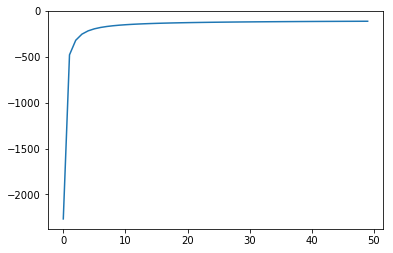

In [13]:
#Now for the code.  Classification rate and forward are the same.
import numpy as np
import matplotlib.pyplot as plt
def forward(x,w1,b1,w2,b2):
    Z=1/(1+np.exp(-x.dot(w1)-b1))#hidden layer
    A=Z.dot(w2)+b2 #pre-softmax
    expA=np.exp(A)
    Y=expA / expA.sum(axis=1,keepdims=True)#axis 0 coloumn 1 row
    return Y,Z #modified to return hidden layer for backprop
def classification_rate(Y,P):
    correct=np.equal(Y,P)
    return float(correct.sum())/correct.size
def cost(T, output):
    total=T*np.log(output)
    return total.sum()
def derivative_w2(Z,T,Y):
    N,K = T.shape
    M=Z.shape[1]
    #slow
#     ret1=np.zeros((M,K))
#     #fast Z.T.dot((T-Y))
#     for n in range(N):
#         for m in range(M):
#             for k in range(K):
#                 ret1[m,k]+=(T[n,k]-Y[n,k])*Z[n,m]
    return  Z.T.dot((T-Y)) #ret1

def derivative_b2(T,Y):
    return (T-Y).sum(axis=0)

def derivative_w1(X,Z,T,Y,W2):
    N,D = X.shape
    M,K=W2.shape
    #slow
#     ret1=np.zeros((D,K))
#     #X.T.dot((T-Y).dot(W2.T)*Z*(1-Z))
#     for n in range(N):
#         for m in range(M):
#             for k in range(K):
#                 for d in range(D):
#                     ret1[d,m]+=(T[n,k]-Y[n,k])*W2[m,k]*Z[n,m]*(1-Z[n,m])*X[n,d]
    return X.T.dot((T-Y).dot(W2.T)*Z*(1-Z))#ret1

def derivative_b1(T,Y,W2,Z):
    return ((T-Y).dot(W2.T)*Z*(1-Z)).sum(axis=0) #subtract Y from T elementwise
#then matrix multiply by the transpose of w2, then elementwise multiply by Z
# and 1-Z then sum over the rows



def main():
    nclass =500
    D,M,K=2,3,3
    x1=np.random.randn(nclass,D)+np.array([0,-2]) #changing mean vectors
    x2=np.random.randn(nclass,D)+np.array([2,2])
    x3=np.random.randn(nclass,D)+np.array([-2,2])
    #labels
    X=np.concatenate((x1,x2,x3),axis=0)
    Y=np.array([0]*nclass+[1]*nclass+[2]*nclass)
    # the dimension D=2 and we want 3 hidden layers M=3
    
    #now turn targets into indicator variable
    N=len(Y)
    T=np.zeros((N,K))
    for i in range(N):
        T[i,Y[i]]=1 #one hot encoding
    
    #randomly initialize weights and then do backprop
    W1=np.random.randn(D,M)
    b1=np.random.randn(M)
    W2=np.random.randn(M,K)
    b2=np.random.randn(K)
    learning_rate=10e-5
    costs=[]
    for epoch in range(1000):
        output, hidden = forward(X,W1,b1,W2,b2)
        if epoch % 100 ==0:
            c = cost(T,output)
            P=np.argmax(output, axis=1) #predictions
            r = classification_rate(Y,P)
            print("cost "+str(c)+" classification rate "+str(r))
            costs.append(c)
        #gradietn ascent
        W2+= learning_rate * derivative_w2(hidden, T ,output)
        b2+=learning_rate * derivative_b2(T, output)
        W1+=learning_rate * derivative_w1(X,hidden,T,output,W2)
        b1+=learning_rate * derivative_b1(T, output, W2, hidden)
    plt.plot(costs)
    plt.show()
main()